# Réplication VAEAC (Olsen et al., 2022) et Analyse de Sensibilité aux Imputations

Ce notebook implémente la méthode **VAEAC** (Variational Autoencoder with Arbitrary Conditioning) pour l'estimation des valeurs de Shapley, en suivant fidèlement l'architecture décrite dans le papier *Using Shapley Values and Variational Autoencoders to Explain Predictive Models with Dependent Mixed Features* (Olsen et al., 2022).

**Objectifs du projet :**
1.  **Implémentation Rigoureuse** : Utilisation des "Skip-Connections" (concaténation entre encodeur masqué et décodeur), activation LeakyReLU, et fonction de perte régularisée (priors sur l'espace latent).
2.  **Analyse de Sensibilité** : Comparaison de l'impact de la méthode d'imputation initiale (Mean, MissForest, Zero) utilisée pour nourrir le *Full Encoder* sur les explications finales (Shapley Values).

**Détails techniques (Section 3 et Annexe C du papier) :**
* **Architecture** : Profondeur 3, Largeur 32, Latent dim 8.
* **Régularisation** : Priors $\mu_{\psi} \sim \mathcal{N}(0, \sigma_{\mu}^2)$ et $\sigma_{\psi} \sim \text{Gamma}$, avec hyperparamètres $10^4$.
* **Entraînement** : Optimiseur Adam ($lr=0.001$), masquage Bernoulli $p=0.5$.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Configuration du périphérique et de la reproductibilité
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

print(f"Environnement configuré. Périphérique : {DEVICE}")

Environnement configuré. Périphérique : cpu


## 1. Préparation des Données (Dataset Abalone)

Nous utilisons le dataset **Abalone** (UCI Machine Learning Repository).
* **Cible** : `Rings` (Âge).
* **Traitement** : Encodage numérique de la variable catégorielle `Sex` et normalisation standard (`StandardScaler`) des variables continues, étape cruciale pour la convergence des VAE.
* **Simulation de données manquantes** : Introduction artificielle de 20% de valeurs manquantes (NaN) pour tester la robustesse des stratégies d'imputation.

In [ ]:
# Chargement du dataset Abalone
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
cols = ["Sex", "Length", "Diameter", "Height", "WholeWeight", "ShuckedWeight", "VisceraWeight", "ShellWeight", "Rings"]
df = pd.read_csv(url, names=cols)

# Encodage de la variable catégorielle 'Sex' (F, M, I -> 0, 1, 2)
le = LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])

# Séparation Features (X) et Cible (y)
X = df.drop(columns=["Rings"]).values.astype(np.float32)
y = df["Rings"].values.astype(np.float32)

# Normalisation (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Création d'un jeu de données avec trous artificiels (20% de NaNs)
mask_missing = np.random.rand(*X_scaled.shape) < 0.2
X_miss = X_scaled.copy()
X_miss[mask_missing] = np.nan

print(f"Données chargées : {X.shape}")
print(f"Données manquantes simulées : {np.isnan(X_miss).sum()} valeurs")

Données chargées : (4177, 8)
Données manquantes simulées : 6640 valeurs


## 2. Architecture du Réseau VAEAC

Cette classe implémente l'architecture exacte du papier (Figure 2 et Annexe C).

* **Masked Encoder (Prior)** : Prend en entrée les données masquées (avec des zéros) et le masque. Produit $z$ et des activations intermédiaires (**skips**).
* **Full Encoder (Proposal)** : Prend en entrée les données complètes (imputées initialement) et le masque. Utilisé uniquement pendant l'entraînement pour guider l'apprentissage.
* **Decoder** : Prend $z$ et les **Skip-Connections** (concaténation des sorties des couches du Masked Encoder) pour reconstruire les données.

Les **Skip-Connections** sont essentielles pour éviter le problème de disparition de gradient et améliorer la reconstruction.

In [ ]:
class SkipBlock(nn.Module):
    """Bloc linéaire simple avec activation LeakyReLU."""
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.LeakyReLU(0.2)  # Activation LeakyReLU comme spécifié
        )

    def forward(self, x):
        return self.net(x)

class VAEAC_Network(nn.Module):
    def __init__(self, input_dim, width=32, depth=3, latent_dim=8):
        super().__init__()
        self.input_dim = input_dim

        # --- 1. Masked Encoder (Prior Network) p_psi ---
        # Input: [Features (masked=0)] + [Mask] -> taille 2 * input_dim
        self.me_input = nn.Linear(input_dim * 2, width)
        self.me_blocks = nn.ModuleList([SkipBlock(width, width) for _ in range(depth)])
        self.me_mu = nn.Linear(width, latent_dim)
        self.me_logvar = nn.Linear(width, latent_dim)

        # --- 2. Full Encoder (Proposal Network) p_phi ---
        # Input: [Features (complets)] + [Mask]
        self.fe_input = nn.Linear(input_dim * 2, width)
        self.fe_blocks = nn.ModuleList([SkipBlock(width, width) for _ in range(depth)])
        self.fe_mu = nn.Linear(width, latent_dim)
        self.fe_logvar = nn.Linear(width, latent_dim)

        # --- 3. Decoder (Generative Network) p_theta ---
        # Input: [z]
        self.dec_input = nn.Linear(latent_dim, width)
        # Input des blocs: [Sortie précédente] + [Skip connection du Masked Encoder] (Concaténation)
        self.dec_blocks = nn.ModuleList([SkipBlock(width * 2, width) for _ in range(depth)])

        self.dec_mu = nn.Linear(width, input_dim)
        self.dec_logvar = nn.Linear(width, input_dim)

    def reparameterize(self, mu, logvar):
        """Trick de reparamétrisation : z = mu + sigma * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward_masked_encoder(self, x_masked, mask):
        # Concaténation données + masque
        x = torch.cat([x_masked, mask], dim=1)
        x = F.leaky_relu(self.me_input(x), 0.2)

        skips = []
        for block in self.me_blocks:
            x = block(x)
            skips.append(x) # On sauvegarde l'activation pour le décodeur

        return self.me_mu(x), self.me_logvar(x), skips

    def forward_full_encoder(self, x_complete, mask):
        x = torch.cat([x_complete, mask], dim=1)
        x = F.leaky_relu(self.fe_input(x), 0.2)
        for block in self.fe_blocks:
            x = block(x)
        return self.fe_mu(x), self.fe_logvar(x)

    def forward_decoder(self, z, skips):
        x = F.leaky_relu(self.dec_input(z), 0.2)

        # Application des Skip-Connections par concaténation
        for i, block in enumerate(self.dec_blocks):
            # Concaténation : [Decoder State, Masked Encoder State]
            x = torch.cat([x, skips[i]], dim=1)
            x = block(x)

        return self.dec_mu(x), self.dec_logvar(x)

    def forward(self, x_complete, x_masked, mask):
        # 1. Masked Encoder (génère aussi les skips)
        m_mu, m_logvar, skips = self.forward_masked_encoder(x_masked, mask)
        # 2. Full Encoder
        f_mu, f_logvar = self.forward_full_encoder(x_complete, mask)
        # 3. Sampling (via Full Encoder pendant le training)
        z = self.reparameterize(f_mu, f_logvar)
        # 4. Decoder
        rec_mu, rec_logvar = self.forward_decoder(z, skips)

        return rec_mu, rec_logvar, f_mu, f_logvar, m_mu, m_logvar

## 3. Fonction de Perte (VLB avec Régularisation)

Nous implémentons la **Variational Lower Bound (VLB)** avec les termes de régularisation spécifiques décrits dans l'Annexe C.3.1 du papier.

La perte se compose de :
1.  **Reconstruction Loss** : Log-vraisemblance négative (Gaussienne).
2.  **Divergence KL** : Entre le Full Encoder $q_\phi$ et le Masked Encoder $p_\psi$.
3.  **Régularisation Prior** : Empêche l'explosion des paramètres de l'encodeur masqué ($\mu_\psi$ et $\sigma_\psi$).
    * Hyperparamètres : $\sigma_{\mu} = 10^4$, $\sigma_{\sigma} = 10^4$.

In [ ]:
def vaeac_loss(x_target, rec_mu, rec_logvar, f_mu, f_logvar, m_mu, m_logvar, mask):
    """
    Calcule la perte VAEAC complète avec régularisation.
    """
    # 1. Reconstruction Loss (NLL Gaussienne)
    rec_std = torch.exp(0.5 * rec_logvar)
    dist = torch.distributions.Normal(rec_mu, rec_std)
    log_prob = dist.log_prob(x_target)

    # On maximise la proba sur tout le vecteur (ou pondéré par le masque selon les variantes)
    recon_loss = -torch.mean(torch.sum(log_prob, dim=1))

    # 2. Divergence KL (Full Encoder || Masked Encoder)
    f_std = torch.exp(0.5 * f_logvar)
    m_std = torch.exp(0.5 * m_logvar)

    p_dist = torch.distributions.Normal(f_mu, f_std)
    q_dist = torch.distributions.Normal(m_mu, m_std)

    kl_loss = torch.mean(torch.sum(torch.distributions.kl_divergence(p_dist, q_dist), dim=1))

    # 3. Régularisation (Prior in Latent Space - Appendix C.3.1)
    # Empêche mu_psi et sigma_psi de diverger vers l'infini
    sigma_mu = 1e4
    sigma_sigma = 1e4

    reg_mu = torch.mean(torch.sum(m_mu**2, dim=1)) / (2 * sigma_mu**2)
    # Approximation du terme Gamma prior
    reg_sigma = torch.mean(torch.sum(torch.exp(m_logvar) - m_logvar, dim=1)) / sigma_sigma

    total_loss = recon_loss + kl_loss + reg_mu + reg_sigma
    return total_loss

## 4. Générateur de Masques et Entraînement

Pour entraîner le VAEAC à gérer n'importe quelle combinaison de variables manquantes (nécessaire pour Shapley), nous utilisons un générateur de masque stochastique.

* **MaskGenerator** : Applique un masque de Bernoulli ($p=0.5$) à chaque batch.
* **Boucle d'entraînement** : Gère l'optimisation des paramètres $\theta, \psi, \phi$ en minimisant la perte définie ci-dessus.

In [ ]:
class MaskGenerator:
    """Génère des masques aléatoires (Bernoulli) pour l'entraînement."""
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, batch):
        # 1 = Manquant, 0 = Observé
        return torch.bernoulli(torch.full_like(batch, self.p))

def train_vaeac(X_train_miss, imputation_method='mean', epochs=40, batch_size=64):
    """Entraîne le modèle VAEAC complet avec une méthode d'imputation spécifique."""
    input_dim = X_train_miss.shape[1]

    # --- A. Imputation Initiale (Pré-traitement pour Full Encoder) ---
    if imputation_method == 'mean':
        imp = SimpleImputer(strategy='mean')
        X_filled = imp.fit_transform(X_train_miss)
    elif imputation_method == 'iterative':
        # MissForest approximation
        estimator = RandomForestRegressor(n_jobs=-1, max_depth=5)
        imp = IterativeImputer(estimator=estimator, max_iter=5, random_state=42)
        X_filled = imp.fit_transform(X_train_miss)
    else: # Zero
        X_filled = np.nan_to_num(X_train_miss, nan=0.0)

    # Conversion en tenseurs
    X_tensor = torch.FloatTensor(X_filled).to(DEVICE)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # --- B. Initialisation Modèle ---
    model = VAEAC_Network(input_dim=input_dim).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    mask_gen = MaskGenerator(p=0.5)

    # --- C. Boucle d'entraînement ---
    model.train()
    print(f"--> Entraînement VAEAC (Init: {imputation_method.upper()})...")

    for epoch in tqdm(range(epochs)):
        for batch in loader:
            x_batch = batch[0]

            # Masque d'entraînement
            mask = mask_gen(x_batch).to(DEVICE)

            # x_complete : Entrée Full Encoder (imputation initiale)
            x_complete = x_batch

            # x_masked : Entrée Masked Encoder (zéros aux endroits masqués)
            x_masked = x_batch.clone()
            x_masked[mask.bool()] = 0

            optimizer.zero_grad()

            # Forward & Loss
            outs = model(x_complete, x_masked, mask)
            loss = vaeac_loss(x_complete, *outs, mask)

            loss.backward()
            optimizer.step()

    return model

## 5. Exécution de l'Analyse Comparative

Nous entraînons maintenant trois modèles VAEAC distincts, chacun initialisé avec une méthode différente pour combler les trous avant l'entrée dans le *Full Encoder* :
1.  **Mean** : Moyenne.
2.  **Iterative** : MissForest (Forêts aléatoires itératives).
3.  **Zero** : Remplissage par zéro.

In [ ]:
# Lancement de l'entraînement comparatif
methods = ['mean', 'iterative', 'zero']
trained_models = {}

for method in methods:
    trained_models[method] = train_vaeac(X_miss, imputation_method=method, epochs=30)

print("Entraînement des 3 modèles terminé.")

--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/30 [00:00<?, ?it/s]

--> Entraînement VAEAC (Init: ITERATIVE)...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

--> Entraînement VAEAC (Init: ZERO)...


  0%|          | 0/30 [00:00<?, ?it/s]

Entraînement des 3 modèles terminé.


## 6. Estimation des Valeurs de Shapley

Une fois le VAEAC entraîné, nous l'utilisons pour calculer l'espérance conditionnelle $\mathbb{E}[f(x) | x_S]$ nécessaire à la formule de Shapley.

* **Procédure** : Pour une coalition $S$, on masque les variables hors de $S$. Le *Masked Encoder* génère une distribution latente, et le *Decoder* produit $K$ imputations plausibles pour les variables manquantes.
* **Modèle Prédictif** : Un RandomForestRegressor (Black-Box) est utilisé pour faire les prédictions sur ces imputations.

In [ ]:
# Modèle Black-Box à expliquer (Random Forest)
# On l'entraîne sur les données imputées simplement pour l'exemple
X_clean_rf = SimpleImputer().fit_transform(X_miss)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_clean_rf, y)

def vaeac_impute(model, x_batch, mask, K=10):
    """Génère K imputations via le Masked Encoder + Decoder (Inférence)."""
    model.eval()
    with torch.no_grad():
        x_batch = x_batch.to(DEVICE)
        mask = mask.to(DEVICE)

        # x_masked : zéros là où mask=1
        x_masked_input = x_batch.clone()
        x_masked_input[mask.bool()] = 0

        # Forward Masked Encoder
        mu, logvar, skips = model.forward_masked_encoder(x_masked_input, mask)

        imputations = []
        for k in range(K):
            z = model.reparameterize(mu, logvar)
            rec_mu, _ = model.forward_decoder(z, skips)

            # Combiner: Valeurs observées + Prédictions
            x_final = x_batch * (1 - mask) + rec_mu * mask
            imputations.append(x_final.cpu().numpy())

        return np.array(imputations) # [K, Batch, Features]

def estimate_shapley(vaeac_model, predictor, x_instance, n_coalitions=100, n_samples_mc=10):
    """Estimation Monte Carlo des valeurs de Shapley."""
    M = len(x_instance)
    phi = np.zeros(M)
    x_tensor = torch.FloatTensor(x_instance).unsqueeze(0) # [1, M]

    # Baseline value (E[f(x)])
    mask_all = torch.ones_like(x_tensor)
    imps_all = vaeac_impute(vaeac_model, x_tensor, mask_all, K=n_samples_mc)
    preds_base = [predictor.predict(imps_all[k])[0] for k in range(n_samples_mc)]
    base_value = np.mean(preds_base)

    # Boucle sur coalitions
    for _ in range(n_coalitions):
        perm = np.random.permutation(M)
        x_S = x_tensor.clone()
        mask = torch.ones_like(x_tensor) # Tout masqué
        prev_val = base_value

        for feature_idx in perm:
            # Ajouter feature i à la coalition S
            mask[0, feature_idx] = 0

            # Calculer E[f(x) | S U {i}] via VAEAC
            imps = vaeac_impute(vaeac_model, x_S, mask, K=n_samples_mc)
            preds = [predictor.predict(imps[k])[0] for k in range(n_samples_mc)]
            curr_val = np.mean(preds)

            # Contribution marginale
            phi[feature_idx] += (curr_val - prev_val)
            prev_val = curr_val

    return phi / n_coalitions

## 7. Résultats et Visualisation

Nous calculons les valeurs de Shapley pour une instance de test spécifique en utilisant les trois modèles VAEAC. Cela nous permet de voir si la méthode d'initialisation influence l'explication finale du modèle prédictif.

Explication pour l'instance 10...
Calcul Shapley avec VAEAC-MEAN...
Calcul Shapley avec VAEAC-ITERATIVE...
Calcul Shapley avec VAEAC-ZERO...


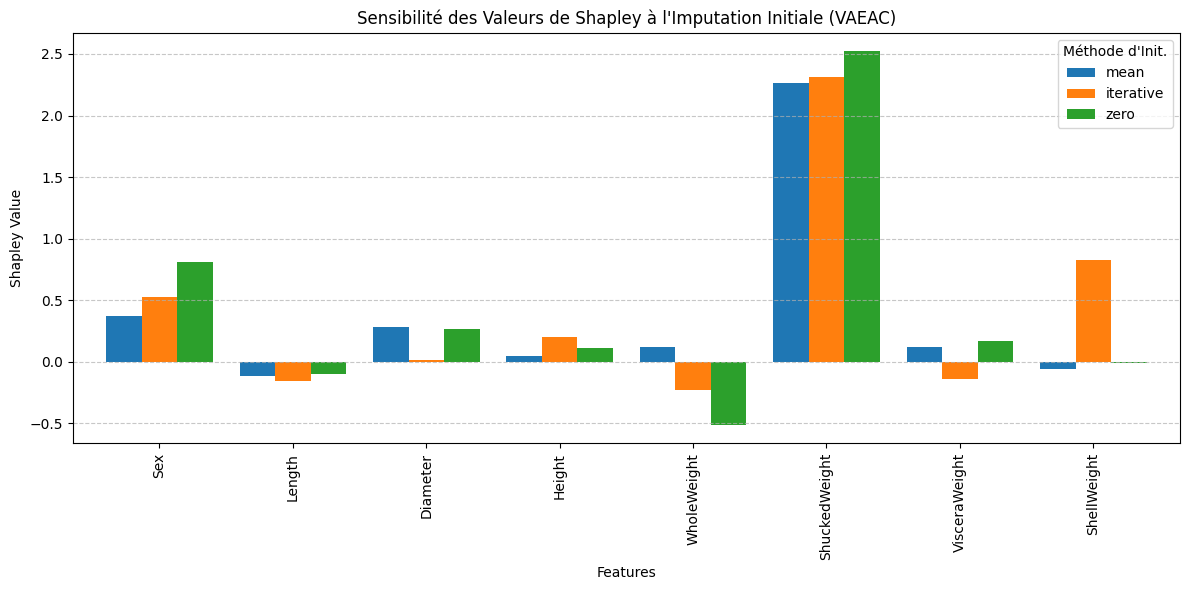


--- Tableau des Résultats ---
                  mean  iterative     zero
Sex            0.37240    0.52951  0.81242
Length        -0.11280   -0.15946 -0.10021
Diameter       0.28171    0.01494  0.26639
Height         0.05046    0.20179  0.11499
WholeWeight    0.12172   -0.23143 -0.51081
ShuckedWeight  2.26102    2.31046  2.52000
VisceraWeight  0.11812   -0.14086  0.17145
ShellWeight   -0.05963    0.82755 -0.00873


In [ ]:
# Sélection d'une instance test
idx = 10
x_test = X_scaled[idx]
print(f"Explication pour l'instance {idx}...")

results = {}
for method_name, model in trained_models.items():
    print(f"Calcul Shapley avec VAEAC-{method_name.upper()}...")
    shap_vals = estimate_shapley(model, rf_model, x_test, n_coalitions=50, n_samples_mc=20)
    results[method_name] = shap_vals

# Graphique comparatif
feature_names = df.columns[:-1]
df_res = pd.DataFrame(results, index=feature_names)

plt.figure(figsize=(12, 6))
df_res.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title("Sensibilité des Valeurs de Shapley à l'Imputation Initiale (VAEAC)")
plt.ylabel("Shapley Value")
plt.xlabel("Features")
plt.legend(title="Méthode d'Init.")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Tableau des Résultats ---")
print(df_res)